In [3]:
from env import DATABASE_URI
from sqlalchemy import create_engine, text, select
from sqlalchemy.orm import Session
import models as dm 
from datetime import datetime
engine = create_engine(DATABASE_URI, echo=False )


In [4]:
##
#### ADD THERMAL MOCKUP
##

# increment by one for the FNAL
THERMAL_MOCKUP_SERIAL_NUMBER = "TM0003"
with Session(engine) as session:
    thermal_mockup = dm.Module(
        name = THERMAL_MOCKUP_SERIAL_NUMBER
    )
    thermal_mockup.info = "Third mockup assembled at FNAL, Nov 20th 2024. Dummies: Micross 21, Micross 22, Micross 23, Micross 25"
    session.add(thermal_mockup)
    session.commit()

In [ ]:
##
#### SOLDER PLATE UPLOAD
##
with Session(engine) as session:
    # # add Cold Plate configuration (epoxy and solder v1 and solder v2)
    with open("/home/hayden/Downloads/pretty_double_loop_solder_plate.png", 'rb') as f:
        plate_image = f.read()
    plate = dm.ColdPlate(
        name='Pretty Double Loop Solder Plate',
        positions = {
            1:  'front side, top row, far left',
            2:  'front side, top row, middle left',
            3:  'front side, top row, middle right',
            4:  'front side, top row, far right',
            5:  'front side, middle row, far left',
            6:  'front side, middle row, middle left',
            7:  'front side, middle row, middle right',
            8:  'front side, middle row, far right',
            9:  'front side, bottom row, far left',
            10: 'front side, bottom row, middle left',
            11: 'front side, bottom row, middle right',
            12: 'front side, bottom row, far right',
            13: 'back side, top row, far left',
            14: 'back side, top row, middle left',
            15: 'back side, top row, middle right',
            16: 'back side, top row, far right',
            17: 'back side, middle row, far left',
            18: 'back side, middle row, middle left',
            19: 'back side, middle row, middle right',
            20: 'back side, middle row, far right',
            21: 'back side, bottom row, far left bottom',
            22: 'back side, bottom row, middle left bottom',
            23: 'back side, bottom row, middle right bottom',
            24: 'back side, bottom row, far right bottom'
        },
        plate_image = plate_image,
    )
    session.add(plate)
    session.commit()

In [4]:
##
#### CALIBRATION DATA
## 
import json

MODULE_SERIAL_NUMBER = 'TM0002'
CALIBRATION_DATA_PATH = "/home/hayden/repos/module_pcb_thermal_mockup/module_pcb_thermal_mockup_v3.5/software/CalibrationGUI/calibration_data_TM0002_2024-12-12 13:39:40.875475.json"

ENABLED_SENSORS = ['E1','E2','E3','E4','L1', "L3"]

CALIBRATION_COMMENT = "This the first calibration done in the TIF Climate Box: Batiment 28 2-020"

with Session(engine) as session:
    query = select(dm.Module).where(dm.Module.name == MODULE_SERIAL_NUMBER)
    thermal_mockup = session.execute(query).scalars().first()
    
    with open(CALIBRATION_DATA_PATH, 'r') as f:
        calib_data = json.load(f)

    db_calibs = []
    for sensor in ENABLED_SENSORS:
        db_calibs.append(
            dm.SensorCalibration(
                module = thermal_mockup,
                sensor = sensor,
                fit_ohms_over_celcius = calib_data[sensor]['fit_slope'],
                fit_ohms_intercept = calib_data[sensor]['fit_intercept'],
                celcius = calib_data[sensor]['temps'],
                ohms = calib_data[sensor]['ohms'],
                raw_adc = calib_data[sensor]['raw_adcs'],
                times = calib_data[sensor]['times'],
                all_raw_adcs = calib_data[sensor]['all_raw_adcs'],
                all_raw_times = calib_data[sensor]['all_times'],
            )
        )
    session.add_all(db_calibs)
    mod_recalib = dm.ModuleCalibration(
        E1 = db_calibs[0],
        E2 = db_calibs[1],
        E3 = db_calibs[2],
        E4 = db_calibs[3],
        L1 = db_calibs[4],
        L3 = db_calibs[5],
        module = thermal_mockup,
        comment=CALIBRATION_COMMENT
    )

    session.add(mod_recalib)

    thermal_mockup.calibration = mod_recalib

    session.commit()

In [3]:
# query runs
with Session(engine) as session:
    module = select(dm.Module).where(dm.Module.name=="TM0002")
    module.info = "Second thermal mockup, assembled at FNAL Nov 20th, 2024. Dummies: Micross 15, Micross 16, Micross 17, Micross 18"
    session.commit()

In [5]:
# query runs
with Session(engine) as session:
    for run in session.execute(select(dm.Run)):
        print(run)

(Run(id=14, mode='DEBUG'), comment='just to see if db connection works and gui is still working',)
(Run(id=1, mode='TEST'), comment='First Run',)
(Run(id=2, mode='TEST'), comment='Checking dead channels for first thermal mockup test in cold box',)
(Run(id=3, mode='REAL'), comment='Epoxy Plate, Back Heaters On, TM-Back-Middle',)
(Run(id=4, mode='REAL'), comment='Epoxy Plate, Back Heaters Off, TM-Back-Middle',)
(Run(id=5, mode='TEST'), comment='checking connectivity',)
(Run(id=6, mode='TEST'), comment='checking connectivity',)
(Run(id=7, mode='REAL'), comment='Epoxy Plate, Front Heaters Off, TM-Front-Middle',)
(Run(id=8, mode='REAL'), comment='Epoxy Plate, Front Heaters On, TM-Front-Middle',)
(Run(id=9, mode='TEST'), comment='debugging',)
(Run(id=10, mode='TEST'), comment='debugging',)
(Run(id=11, mode='TEST'), comment='checking the working of sensors',)
(Run(id=12, mode='REAL'), comment='Solder Plate, No Heater, TM-Back-Middle',)
(Run(id=13, mode='REAL'), comment='Solder Plate, No Heate

Module(id=3, name='TM0002')
Module(id=3, name='TM0002')


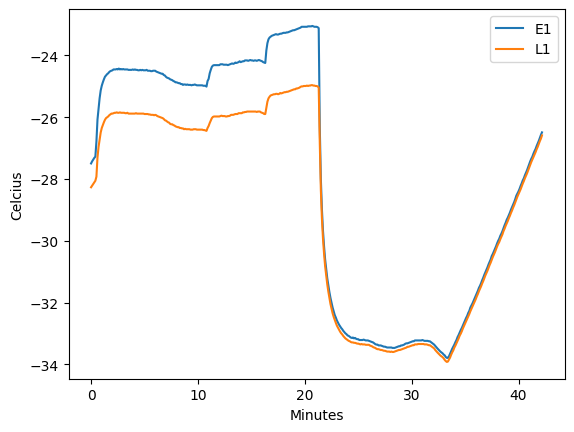

In [ ]:
# QUERYING
import matplotlib.pyplot as plt

def get_sensor_data(run:int, module: str, sensor: str):
    module = session.execute(select(dm.Module).where(dm.Module.name == module)).scalar()
    print(module)
    query = select(dm.Data).where(
        dm.Data.run_id==run, dm.Data.sensor==sensor, dm.Data.module == module)

    data = session.execute(query.order_by(dm.Data.id)).scalars().all()
    return data

def elapsed_time(time: list):
    t0 = time[0]
    return [(t - t0).total_seconds() / 60 for t in time]

def sensor_plot(data:list[dm.Data], **kwargs):
    y_data = [d.celcius for d in data]
    ts = elapsed_time([t.timestamp for t in data])

    plt.plot(ts, y_data, **kwargs)

with Session(engine) as session:
    run = 36
    module = "TMO002"
    etroc = "E1"
    lgad = "L1"
    E_data = get_sensor_data(run, module, etroc)
    L_data = get_sensor_data(run, module, lgad)

    start_idx, stop_idx = 0, 2000
    sensor_plot(E_data[start_idx:stop_idx], label=etroc)
    sensor_plot(L_data[start_idx:stop_idx], label=lgad)
    # dT = np.array([e.celcius - l.celcius for e, l in zip(E3_data, L3_data)])

    # print(np.mean(dT[start_idx:stop_idx]))
    # plt.plot(elapsed_time([t.timestamp for t in E3_data[start_idx:stop_idx]]), dT[start_idx:stop_idx])

    plt.xlabel('Minutes')
    plt.ylabel("Celcius")
    plt.legend()

In [25]:
from pydantic import BaseModel, field_validator, ConfigDict, model_validator, model_serializer
from typing import Optional
from functools import partial

# def db_exists_validator(cls, value, db_model, column):
#     if isinstance(value, str):
#         # Query for module
#         obj = cls.session.execute(
#             select(db_model).where(column == value)
#         ).scalar()

#         assert obj is not None, f"{db_model.__name__} not found in database"
#         return obj
#     return value


class DBBaseModel(BaseModel):

    @classmethod
    def set_session(cls, session):
        cls.session = session

    @classmethod
    def exists_validator(cls, value, db_model, column):
        if isinstance(value, str):
            # Query for module
            obj = cls.session.execute(
                select(db_model).where(column == value)
            ).scalar()

            assert obj is not None, f"{db_model.__name__} not found in database"
            return obj
        return value

class ModuleConfig(DBBaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    mod: dm.Module
    
    _mod_exists_validator = field_validator('mod', mode='before')(
        partial(DBBaseModel.exists_validator, db_model=dm.Module, column=dm.Module.name)
    )
    # @field_validator('mod', mode='before')
    # @classmethod
    # def validate_mod(cls, v: str) -> dm.Module:
    #     if isinstance(v, str):
    #         # Query for module
    #         module = cls.session.execute(
    #             select(dm.Module).where(dm.Module.name == v)
    #         ).scalar()

    #         assert module is not None, "Module not found in database"
    #         return module
    #     return v



# Example usage

DBBaseModel.set_session(session)
module_instance = ModuleConfig(mod="TM0001")
print(module_instance.mod)

print(module_instance)

Module(id=1, name='TM0001')
mod=Module(id=1, name='TM0001')


In [30]:
with Session(engine) as session:
    module = session.execute(select(dm.Module).where(dm.Module.name == "TM0001")).scalar()
    print(module.calibration)

ModuleCalibration(id=4, comment='This is the recalibration for the thermal mockup that was done by Hayden at IRRAD')


In [ ]:
"""
Probe 1: 0xf6b3
Probe 2: 0xf6d3
Probe 3: 0xf6db
"""
